In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests, gzip
import numpy as np
def get(url):
    return np.frombuffer(gzip.decompress(requests.get(url).content), dtype=np.uint8)

X_train = get("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = get("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

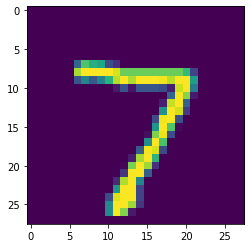

In [4]:
from matplotlib.pyplot import imshow
imshow(X_test[0])

In [5]:
import torch
torch.set_printoptions(sci_mode=False)
# Feature Scaling
X_train_scaled = torch.tensor([np.reshape(xi/256, (-1)) for xi in X_train], dtype=torch.float32)
X_test_scaled = torch.tensor([np.reshape(xi/256, (-1, 28*28)) for xi in X_test], dtype=torch.float32)

# One-Hot encoded targets
y_train_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_train]
y_test_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_test]

y_train_torch = torch.tensor(y_train.copy())
y_test_torch = torch.tensor(y_test.copy())
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_ds = TensorDataset(X_train_scaled, y_train_torch)
test_ds = TensorDataset(X_test_scaled, y_test_torch)
BS = 250
train_dl = DataLoader(train_ds, BS, shuffle=True)
test_dl = DataLoader(test_ds)

/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_23057/2845450077.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  X_train_scaled = torch.tensor([np.reshape(xi/256, (-1)) for xi in X_train], dtype=torch.float32)


In [6]:
import model
torch.manual_seed(0)
model = model.conNet()
x = X_test_scaled[0]
x = torch.tensor(x.reshape((-1, 28*28)), dtype=torch.float32)
model.forward(x)

/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_23057/733587254.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.reshape((-1, 28*28)), dtype=torch.float32)


tensor([[-144.6187, -747.2369,    0.0000, -444.3639, -228.1190, -872.8916,
         -251.4371, -309.6400,  -35.3154, -211.1194]],
       grad_fn=<LogSoftmaxBackward0>)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
N_EPOCH = 100
LR = 0.01
loss_hist = np.zeros(N_EPOCH)
accuracy_hist = np.zeros(N_EPOCH)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in tqdm(range(N_EPOCH)):
    for x_batch, y_batch in train_dl:
        # print(pred[0], y_batch[0])
        # imshow((x_batch[0][0]*256).reshape(28,28))
        b_x = Variable(x_batch)
        b_y = Variable(y_batch)
        pred = model.forward(b_x)
        loss = loss_fn(pred, b_y)
        # clear gradients for this training step
        optimizer.zero_grad()
        # backprop, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        loss_hist[epoch] += loss.item()*y_batch.size()[0]
print(loss_hist)

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

[37958.00464321 28174.55793452 20835.23336239 13189.06996632
 10927.91092582 10541.74492016  7653.77443226  7705.5995863
  7872.61398853  6813.36587956  6682.7491005   6118.36319236
  6586.97446069  4808.77724284  5422.25996808  5435.59096594
  4037.89485379  3969.9724591   3987.57027858  4753.56564979
  4460.20466335  4626.92307852  3739.90935005  4493.60047493
  3239.3718736   3807.04125151  3716.10580316  3516.03207387
  3310.07019638  3218.41267347  3076.44608713  3704.17353325
  3522.86356583  2957.99368612  3248.84679754  3546.71988751
  3256.18778887  2805.16759532  3073.10191239  3960.63059666
  2713.57081531  2149.4093448   3260.06168082  2649.80201098
  2261.71237802  3282.89052789  2036.07938815  2188.07713913
  2299.16067965  2807.71781256  2751.86225073  3444.97750806
  2741.73061445  2809.82309167  3002.18508388  2719.32777416
  2273.19417633  1701.89100752  2200.71921679  2014.92894697
  1211.99437326  1647.22828831  2274.50192388  3666.55751478
  3114.35179607  1756.085

In [31]:
with torch.no_grad():
    n_correct = 0
    for x, target in test_dl:
        # b_x = Variable(x)[0]
        b_x = x
        pred = model.forward(b_x)
        top_1 = torch.argmax(pred)
        n_correct += (top_1 == target)
    print(f'accuracy: {n_correct[0]/10_000*100}%')

accuracy: 9.800000190734863%
